In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import mydataset

In [ ]:
# If you have not generate waveforms, run the following script
!conda activate dl4gw
!mkdir data/
!./generate_waveform.py
!./generate_testdata.py

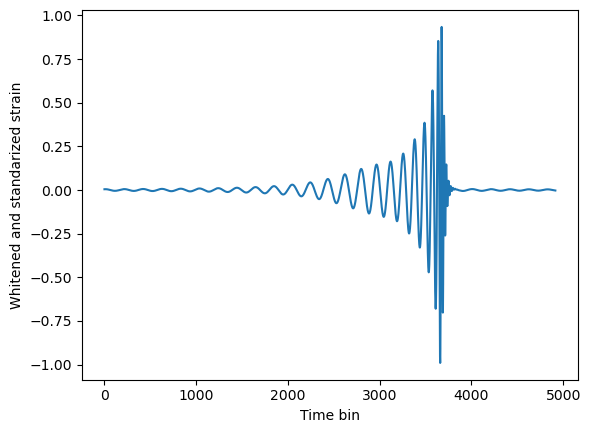

In [2]:
# See the generated waveforms
signals_val = torch.load('data/inputs_validate.pth', weights_only=False)[:, 0:1, :]
idx = 0
plt.figure()
plt.plot(signals_val[idx, 0])
plt.xlabel('Time bin')
plt.ylabel('Whitened and standarized strain')
plt.show()

In [3]:
# Define the network model
class CNN4CBCSearch(nn.Module):
    def __init__(self):
        super(CNN4CBCSearch, self).__init__()
        layers = []
        # Convolutional layers
        layers.append(nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=0, dilation=2))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1))
        layers.append(nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7, stride=1, padding=0, dilation=2))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1))
        layers.append(nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7, stride=1, padding=0, dilation=2))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1))
        layers.append(nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7, stride=1, padding=0, dilation=2))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1))
        # Fully-connected layers
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=3872, out_features=64))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(in_features=64, out_features=2))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [4]:
# Define the model
model = CNN4CBCSearch()

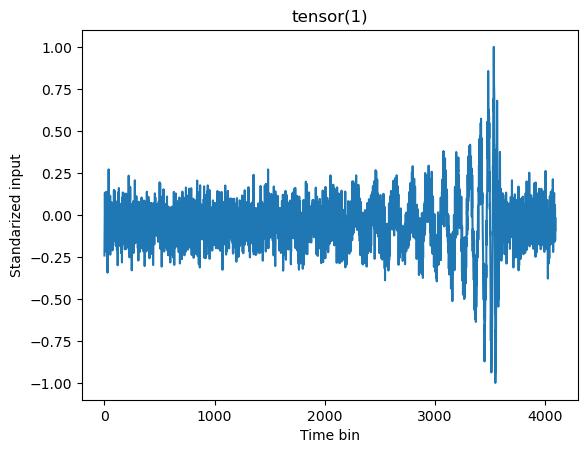

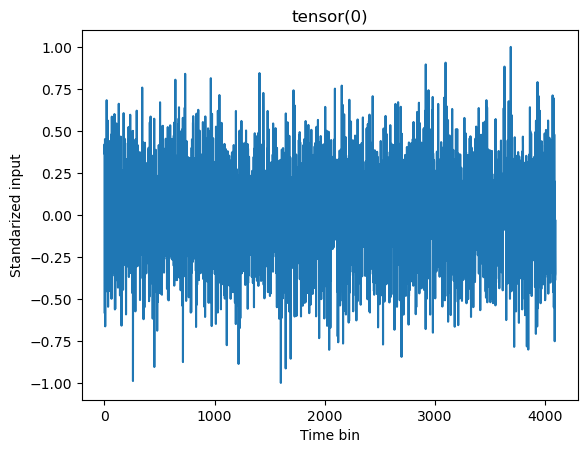

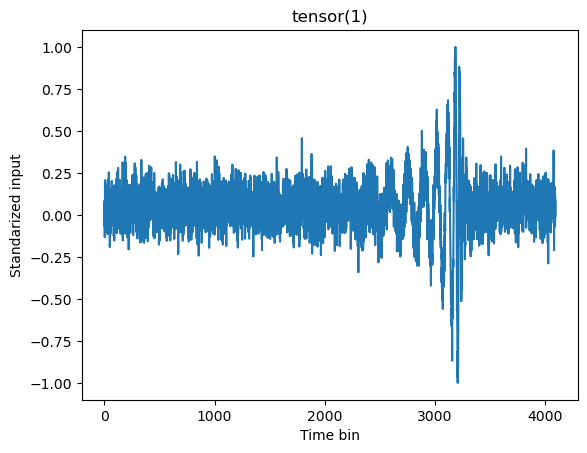

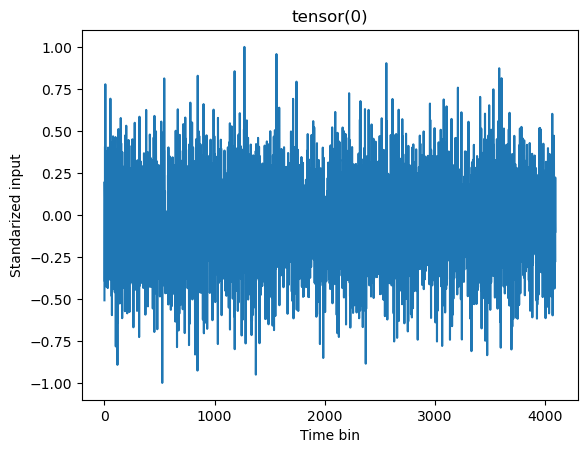

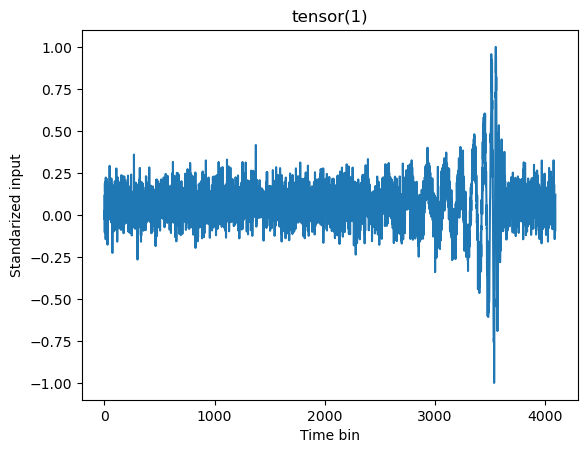

In [5]:
# Check how the dataloader works.
inputsize = 4096
transforms = nn.Sequential(
    mydataset.MimicTimeTranslation(inputsize),
    mydataset.InjectSignalIntoNoise(std=0.1),
    mydataset.NormalizeTensor(),
)

signals_tr = torch.load('data/inputs_train.pth', weights_only=False)[:, 0:1, :]
dataset_tr = mydataset.MyDataset(signals_tr, transform=transforms)
dataloader_tr = DataLoader(dataset_tr, batch_size=64, shuffle=True, drop_last=True)

# Check if the dataloader works.
for (inputs, labels) in dataloader_tr:
    break

for i in range(5):
    plt.figure()
    plt.plot(inputs[i, 0])
    plt.xlabel('Time bin')
    plt.ylabel('Standarized input')
    plt.title(labels[i])
plt.show()

In [6]:
# Define the data loader again after plotting input data
inputsize = 4096
transforms = nn.Sequential(
    mydataset.MimicTimeTranslation(inputsize),
    mydataset.InjectSignalIntoNoise(std=0.1),
    mydataset.NormalizeTensor(),
)

signals_tr = torch.load('data/inputs_train.pth', weights_only=False)[:, 0:1, :]
dataset_tr = mydataset.MyDataset(signals_tr, transform=transforms)
dataloader_tr = DataLoader(dataset_tr, batch_size=64, shuffle=True, drop_last=True)

signals_val = torch.load('data/inputs_validate.pth', weights_only=False)[:, 0:1, :]
dataset_val = mydataset.MyDataset(signals_val, transform=transforms)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=False, drop_last=True)

In [7]:
# Define loss function and optimizer
from torch.optim import Adam

lossfunction = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters() ,lr=1e-4)

In [8]:
# Train the network
for i_epoch in range(10):
    # Training step
    running_loss = 0.0
    model.train()
    for i_tr, (x, t) in enumerate(dataloader_tr):
        y = model(x)
        loss = lossfunction(y, t)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= (i_tr + 1)

    # validate step
    valloss = 0.0
    model.eval()
    for i_val, (x, t) in enumerate(dataloader_val):
        y = model(x)
        loss = lossfunction(y, t)
        valloss += loss.item()
    valloss /= (i_val + 1)

    print(f"Epoch {i_epoch + 1}: {running_loss:.5e} {valloss:.5e}")

Epoch 1: 6.47413e-01 5.86910e-01
Epoch 2: 4.46941e-01 2.80017e-01
Epoch 3: 1.45703e-01 5.14505e-02
Epoch 4: 2.48075e-02 1.12034e-02
Epoch 5: 6.38640e-03 4.00749e-03
Epoch 6: 2.54752e-03 1.76746e-03
Epoch 7: 1.42621e-03 9.89454e-04
Epoch 8: 7.80868e-04 6.89097e-04
Epoch 9: 6.26621e-04 5.21094e-04
Epoch 10: 4.00983e-04 3.49492e-04


# Test

`generate_testdata.py` will generate 1024 s simulated data. In this data, four CBC signals are injected. Segments with durations of 1 s are cropped with an overlap of 0.125 s. The softmax function is applied to the output of the neural network.

In [9]:
# Test the trained network
t_stride = 1.0 / 8.0
fs = 4096
l_stride = int(t_stride * fs)
normalize = mydataset.NormalizeTensor()
testdata = torch.tensor(np.load('data/test_strain.npy'), dtype=torch.float32)
outputlist = []
with torch.no_grad():
    for i in tqdm(range(int(1023 / t_stride))):
        kstart = i * l_stride
        testbatch = testdata[kstart: kstart + 4096].view((1, 1, -1))
        x = normalize(testbatch)
        y = torch.softmax(model(x), dim=-1)
        outputlist.append(y[0, 1].item())

  0%|          | 0/8184 [00:00<?, ?it/s]

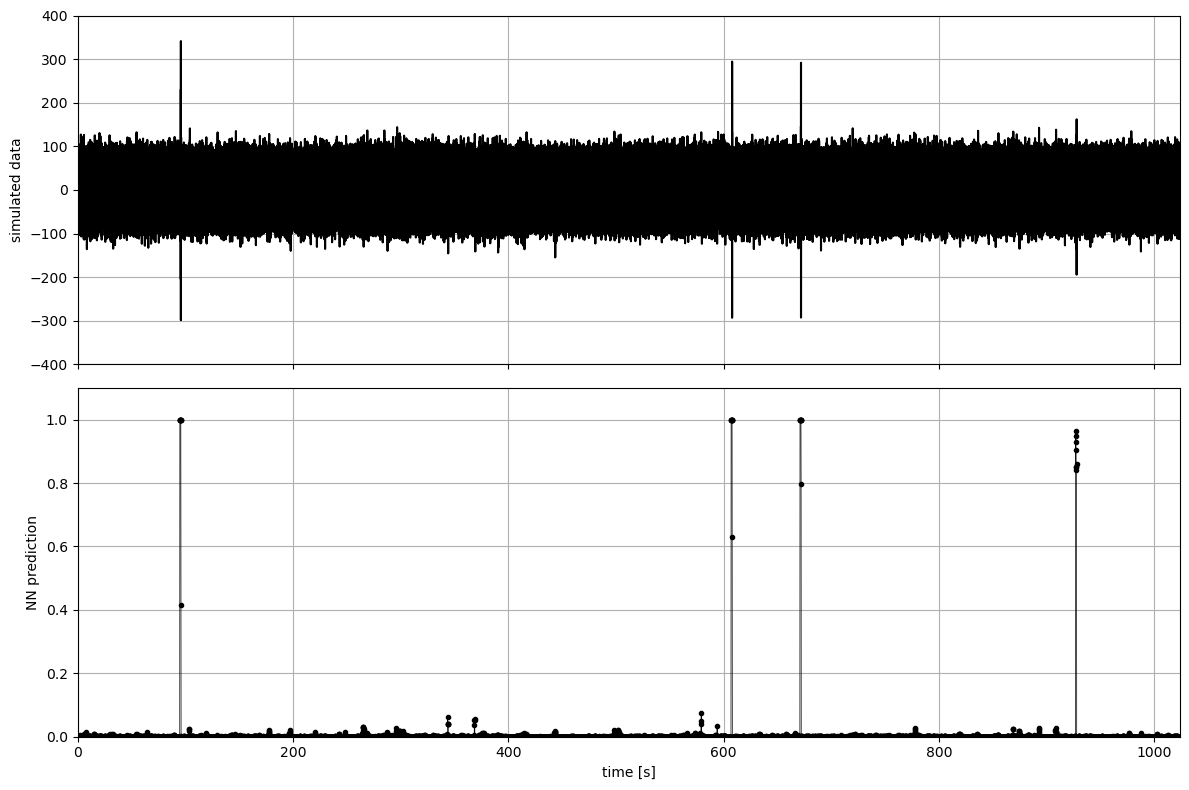

In [10]:
tsample = np.arange(fs * 1024) / fs
tflag = np.arange(len(outputlist)) * t_stride + (t_stride / 2)

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True, tight_layout=True)
ax[0].plot(tsample, testdata, c='k')
ax[1].plot(tflag, outputlist, '.-', c='k', lw=0.5)
ax[0].set(ylabel='simulated data', xlim=[0, 1024], ylim=[-400, 400])
ax[1].set(xlabel='time [s]', ylabel='NN prediction', xlim=[0, 1024], ylim=[0, 1.1])
ax[0].grid()
ax[1].grid()
plt.show()

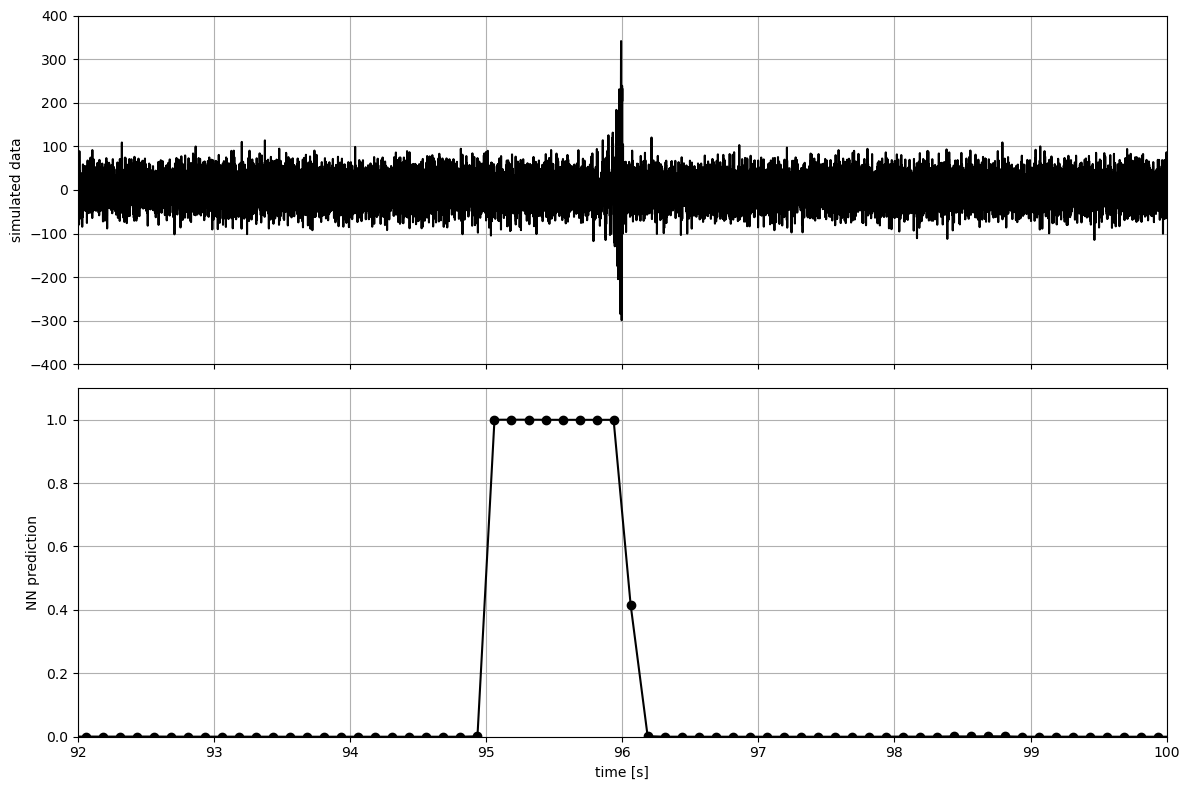

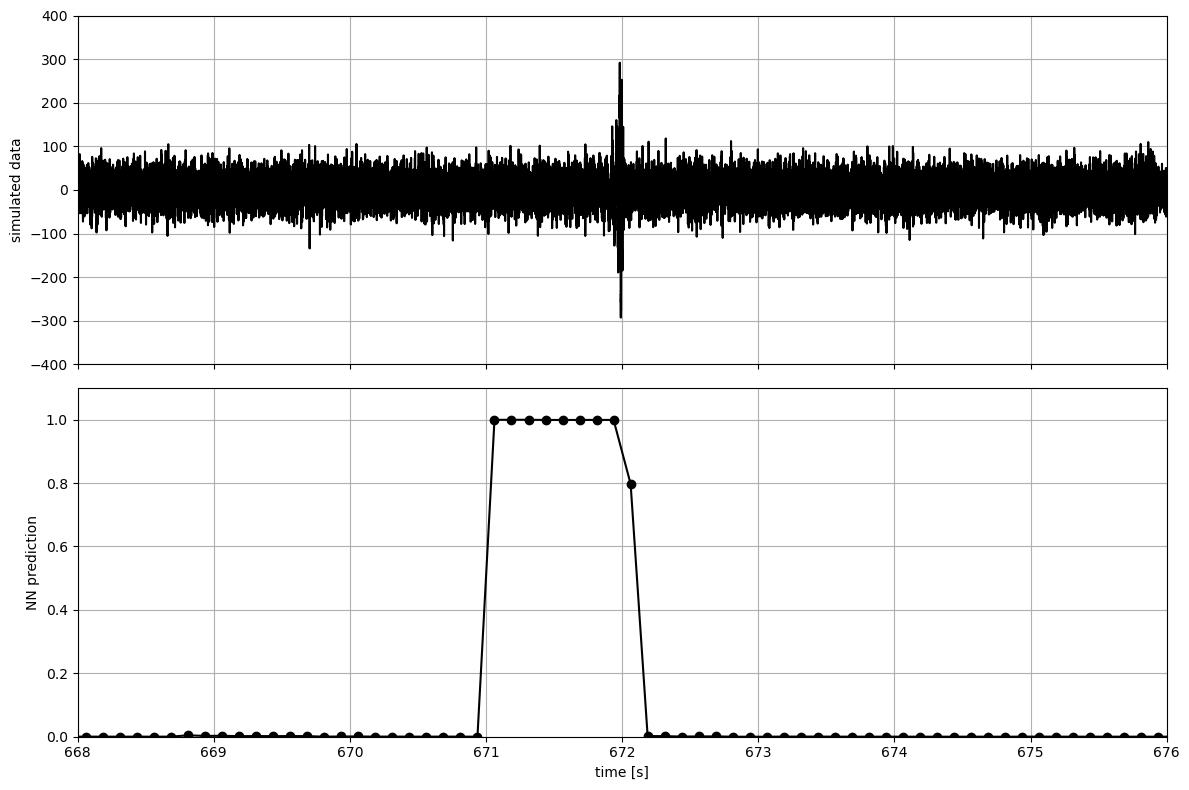

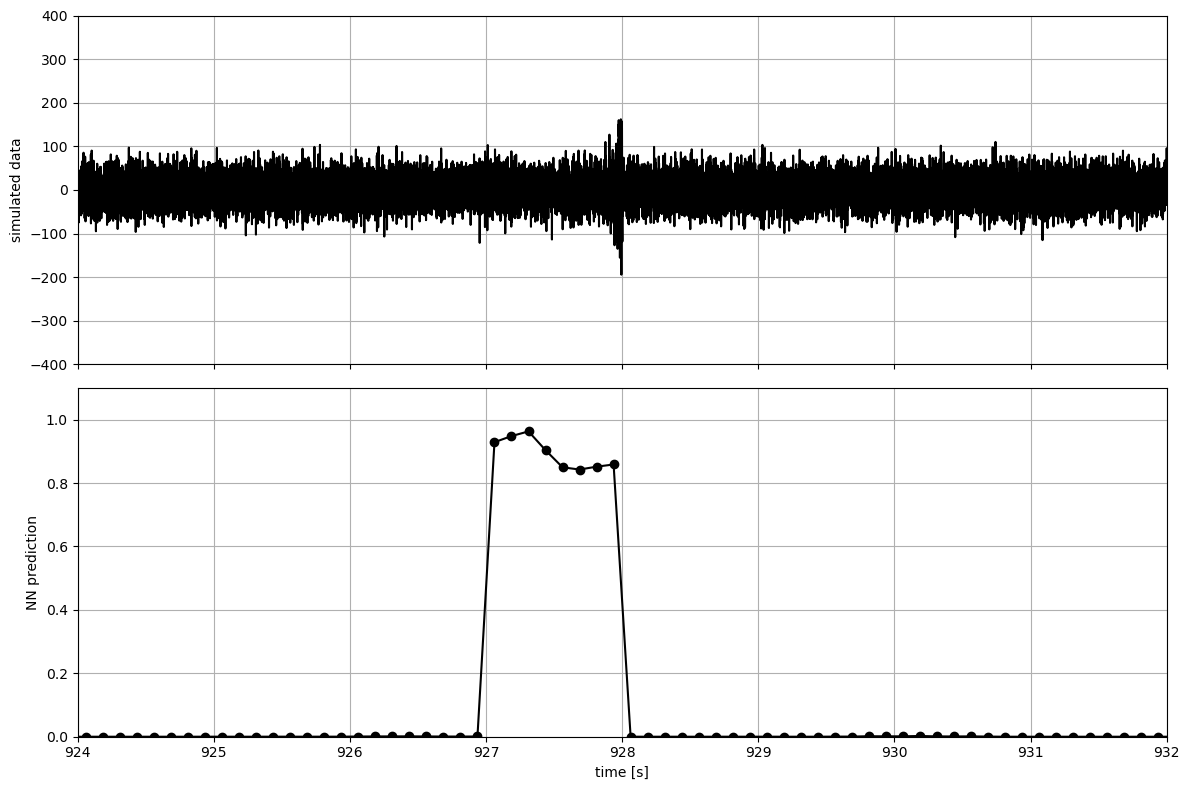

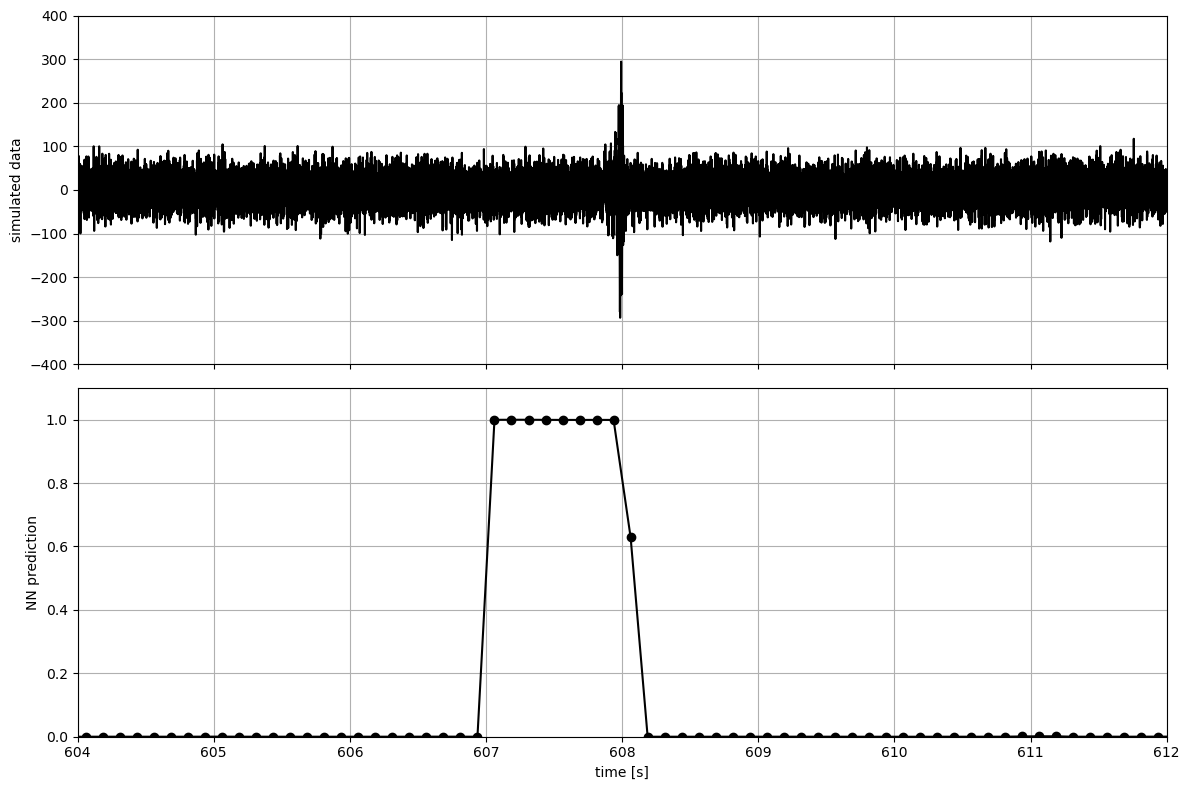

In [11]:
dt = 4.0
tc_injection = np.genfromtxt('./data/injection_time.txt')
for tc in tc_injection:

    fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True, tight_layout=True)
    ax[0].plot(tsample, testdata, c='k')
    ax[1].plot(tflag, outputlist, 'o-', c='k')
    ax[0].set(ylabel='simulated data', xlim=[tc - dt, tc + dt], ylim=[-400, 400])
    ax[1].set(xlabel='time [s]', ylabel='NN prediction', xlim=[tc - dt, tc + dt], ylim=[0, 1.1])
    ax[0].grid()
    ax[1].grid()
plt.show()